In [1]:
import os
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import cv2
import warnings
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
tf.random.set_seed(42)
#warnings.filterwarnings("ignore")

Init variables (in the script for now, via config file later)

In [2]:
config = None

# Global
index = 4

# For data
path = '/home/mlmaster/Code/Ing_ml_P6/dataset/'
img_height = 150
img_width = 150
zca_whitening = False
horizontal_flip = True

# For model
model_type = 3
batch_size = 50
learning_rate = 0.001
epochs = 50
steps_per_epoch = 5
validation_steps = 10

# For Logs
save = "/home/mlmaster/Code/Ing_ml_P6/logs/"

Building Dataset for logs

In [3]:
dataset = [index, img_height, img_width, batch_size,
           learning_rate, epochs, steps_per_epoch,
           validation_steps, zca_whitening, horizontal_flip,
           model_type]

dataset = pd.DataFrame(dataset).T
dataset = dataset.rename(columns={0:'Index', 1:'Img Height', 2:'Img Width', 3:'Batch Size',
                                  4:'Learning Rate', 5:'Epochs', 6:'Steps Per Epoch',
                                  7:'validation Steps', 8:'Zca Whitening', 9:'Horizontal Flip',
                                  10:'Model Type'})

In [4]:
dataset

,Index,Img Height,Img Width,Batch Size,Learning Rate,Epochs,Steps Per Epoch,validation Steps,Zca Whitening,Horizontal Flip,Model Type
0,4,150,150,50,0.001,50,5,10,False,True,3


In [5]:
# Locked variable, does not change with config file
train = 'Train/'
val = 'Validation/'
test = 'Test/'
fullPathTrain = path + train
fullPathVal = path + val
fullPathTest = path + test

# For model
train_datagen =  ImageDataGenerator(
    zca_whitening=zca_whitening,
    horizontal_flip=horizontal_flip,
    rescale=1./255
)

val_datagen =  ImageDataGenerator(
    rescale=1./255
)

test_datagen =  ImageDataGenerator(
    rescale=1./255
)

In [6]:
#setting the path to the directory containing the pics
categories = []
for i in os.listdir(fullPathTrain):
    categories.append(i)

In [7]:
def load_data(which='Train', categories=categories):
    
    """Function that loads data and resize the images"""
    
    if which == 'Train':
        path = fullPathTrain
        print('Loading Train Data')
    elif which == 'Val':
        path = fullPathVal
        print('Loading Validation Data')
    elif which == 'Test':
        path = fullPathTest
        print('Loading Test Data')
    else:
        print('error, which must be either : Train, Val, Test')
    data = []
    label = []
    for i in categories:
        for img in os.listdir(path + i):
            pic = cv2.imread(os.path.join(path + i,img))
            pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
            pic = cv2.resize(pic,(img_height, img_width))
            data.append([pic])
            label.append(i)
    print(len(data), " Images loaded")
    # Formating data
    data = np.array(data)
    data = data.reshape((data.shape[0], img_height, img_width, 3))
    data = data.astype('float32')
    label = np.array(label)
    label = [i.split('-')[1] for i in label]
    
    return data, label

Fit if zca_whitening is True

In [8]:
if zca_whitening == True:
    dataToFit, label = load_data(which='Train', categories=categories)
    dataToFit = dataToFit.reshape((dataToFit.shape[0], img_height, img_width, 3))
    dataToFit = dataToFit.astype('float32')
    train_datagen.fit(dataToFit)
    # This fail with error :
    # "ValueError: Too large work array required -- 
    # computation cannot be performed with standard 32-bit LAPACK."

In [9]:
# Defining the generator
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
                                fullPathTrain,
                                target_size = (img_height, img_width),
                                batch_size = batch_size, 
                                class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
                             fullPathVal,
                             target_size = (img_height, img_width),
                             batch_size = batch_size,
                             class_mode = "categorical",
                             shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
                              fullPathTest,
                              target_size = (img_height, img_width),
                              batch_size = batch_size,
                              class_mode = "categorical",
                              shuffle=False)

Total number of images for "training":
Found 12348 images belonging to 120 classes.
Total number of images for "validation":
Found 4116 images belonging to 120 classes.
Total number of images for "testing":
Found 4116 images belonging to 120 classes.


In [10]:
# Model Builder
if model_type == 1:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(img_height,img_width,3)))
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_height,img_width,3)))
    model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(img_height,img_width,3)))
    model.add(Conv2D(8, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(categories), activation='softmax'))
    
elif model_type == 2:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_height,img_width,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))
    
elif model_type == 3:
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=(img_height,img_width,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))
    
elif model_type == 4:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2),
                     activation='relu',
                     input_shape=(img_height,img_width,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
    
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))    

In [11]:
# Optmizer and compilation
opt = Adam(lr=learning_rate, clipnorm=1.)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 8)       608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        5

In [13]:
# Model fit via generator
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1)

Epoch 1/50
5/5 [==============================] - 3s 644ms/step - loss: 0.4970 - accuracy: 0.0096 - val_loss: 0.1161 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 3s 545ms/step - loss: 0.1394 - accuracy: 0.0178 - val_loss: 0.1134 - val_accuracy: 0.0840
Epoch 3/50
5/5 [==============================] - 3s 544ms/step - loss: 0.1033 - accuracy: 0.0065 - val_loss: 0.0636 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 3s 555ms/step - loss: 0.0774 - accuracy: 0.0083 - val_loss: 0.0530 - val_accuracy: 0.0840
Epoch 5/50
5/5 [==============================] - 2s 527ms/step - loss: 0.0562 - accuracy: 0.0096 - val_loss: 0.0637 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 2s 524ms/step - loss: 0.0594 - accuracy: 0.0000e+00 - val_loss: 0.0574 - val_accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 2s 529ms/step - loss: 0.0546 - accuracy: 0.0070 - val_loss: 0.0573 - val_accuracy: 0.0000e

Ploting graph

[]

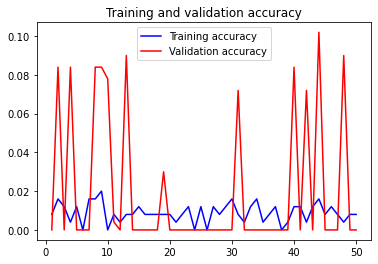

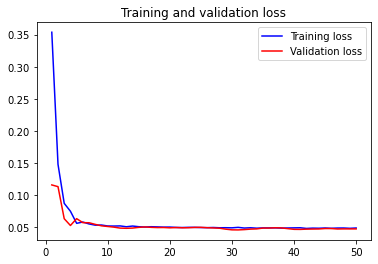

In [14]:
path_img = save + str(index) + '/'
try:
    os.mkdir(path_img)
except:
    print('This directory already exists, please make sure that you changed the index')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(path_img + 'Accuracy.jpg')
plt.plot()

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(path_img + 'Loss.jpg')
plt.plot()

Saving best scores

In [15]:
val_acc = max(history.history['val_accuracy'])
val_loss = max(history.history['val_loss'])

dataset['Validation Accuracy'] = val_acc
dataset['Validation Loss'] = val_loss

In [16]:
try:
    logs = pd.read_csv('logs.csv')
    logs = pd.concat([logs, dataset])
    logs.to_csv(save + 'logs.csv')
except:
    dataset.to_csv(save + 'logs.csv')

In [17]:
import keras
from numba import cuda
# Clearing session as we will train model many time
keras.backend.clear_session()
# Releasing gpu memory directly with cuda
cuda.select_device(0)
cuda.close()